In [125]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset

from sklearn.model_selection import train_test_split

import seaborn as sns

import requests
import io
import pandas as pd

import zipfile
import re
import os

import unicodedata
import string

In [126]:
all_letters = string.ascii_lowercase + " .,;'"
n_letters = len(all_letters)
url = "https://download.pytorch.org/tutorial/data.zip"

In [127]:
def unicodeToAscii(s):
    return ''.join(
        c for c in unicodedata.normalize('NFD', s)
        if unicodedata.category(c) != 'Mn'
        and c in all_letters
    )

def readfile(filename, z):
    content = z.read(filename)
    language = os.path.splitext(os.path.basename(filename))[0]
    names = content.decode("utf-8").split("\n")
    return language, [unicodeToAscii(name.strip().lower()) for name in names if len(name.strip()) > 0]

def buildnames(url):
    response = requests.get(url)
    b = io.BytesIO(response.content)
    z = zipfile.ZipFile(b)
    
    pattern = re.compile(r"^data/names/(\w+)\.txt")
    filenames = [f.filename for f in z.infolist() if re.match(pattern, f.filename)]
    
    all_names = []
    
    for filename in filenames:
        language, names = readfile(filename, z)
        all_names += list(zip([language]*len(names), names))
        
    return pd.DataFrame(all_names, columns=["language", "person_name"])

In [133]:
def letter_to_index(letter):
    return all_letters.find(letter) + 1 # zero is reserved for padding
    
def name_to_tensor(name, max_len):
    name = name.lower()
    name_tensor = torch.zeros((max_len), dtype=torch.long)
    for i, letter in enumerate(name):
        if i < max_len:
            name_tensor[i] = letter_to_index(letter)
            
    return name_tensor

In [134]:
name_to_tensor('ashok', max_len)

tensor([ 1, 19,  8, 15, 11,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,
         0])

### Torch dataset

In [113]:
class NamesDataset(Dataset):
    def __init__(self, dataframe, max_len):
        self.dataframe = dataframe
        self.max_len = max_len
        
    def __len__(self):
        return len(self.dataframe.index)
    
    def __getitem__(self, item):
        row = self.dataframe.loc[item]
        
        name = row.person_name
        language = row.language
        
        language_idx = language_to_idx[language]
        name_tensor = name_to_tensor(name, self.max_len)
        
        return {
            "language_idx": torch.tensor(language_idx, dtype=torch.long),
            "name_tensor": name_tensor
        }

### The Embedding layer
Embedding layer is initialized with a shape `(num_embeddings, embedding_dim)`. The first dimension corresponds to the max index. For example, if we want to train a character level network with 27 characters (space + 26 alphabets), then we will used `num_embeddings=27`. The layer will be initialized with random values that will be learned during training. 

In [212]:
class CharacterNet(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, output_size):
        super(CharacterNet, self).__init__()
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.output_size = output_size
        
        self.embedding = nn.Embedding(input_size, embedding_dim)
        self.rnn = nn.RNN(embedding_dim, hidden_size)
        self.linear = nn.Linear(hidden_size, output_size)
        
    def forward(self, x):
        x = torch.transpose(x, 1, 0)
        x = self.embedding(x)
        out, hidden = self.rnn(x)
        x = self.linear(hidden[-1])
        return x

In [213]:
def train_epoch():
    train_losses, valid_losses = [], []
    train_loss, valid_loss = 0, 0
    
    model.train()
    for train_data in train_dataloader:
        name_tensor = train_data["name_tensor"]
        language_idx = train_data["language_idx"]
        
        with torch.set_grad_enabled(True):
            output = model(name_tensor)
            loss = loss_function(output, language_idx)
            
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
            train_loss += loss.item()
            train_losses += [loss.item() / len(train_data)]
        
    model.eval()
    for valid_data in valid_dataloader:
        name_tensor = valid_data["name_tensor"]
        language_idx = valid_data["language_idx"]
        
        with torch.set_grad_enabled(False):
            output = model(name_tensor)
            loss = loss_function(output, language_idx)
    
            valid_loss += loss.item()
            valid_losses += [loss.item() / len(valid_data)]
    
    # plotting losess
    ax = sns.lineplot(list(range(len(train_losses))), train_losses, label="train")
#     ax = sns.lineplot(list(range(len(valid_losses))), valid_losses, label="valid")
#     ax.set_title(f"Train and valid losses");
    
    train_loss /= len(train_dataloader.dataset)
    valid_loss /= len(valid_dataloader.dataset)
    
    print(f"Epoch train loss: {train_loss:.4f}, Epoch valid loss: {valid_loss:.4f}")
        
    return train_loss, valid_loss

In [137]:
names = buildnames(url)
languages = names.language.unique()
nlanguages = len(languages)
max_len = names.person_name.apply(len).max() 

language_to_idx = dict([(language, i) for (i, language) in enumerate(languages)])
idx_to_language = dict([(i, language) for (language, i) in language_to_idx.items()])

train, valid = train_test_split(names, test_size=0.2)

In [214]:
batch_size = 32

train_dataset = NamesDataset(train.reset_index(), max_len)
valid_dataset = NamesDataset(valid.reset_index(), max_len)

train_dataloader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
valid_dataloader = DataLoader(valid_dataset, batch_size=batch_size, shuffle=True)

In [215]:
model = CharacterNet(n_letters+1, 10, 10, nlanguages)

In [216]:
loss_function = nn.CrossEntropyLoss(reduction="sum")
optimizer = optim.Adam(model.parameters(), lr=0.0001)

Epoch train loss: 2.5890, Epoch valid loss: 2.2900


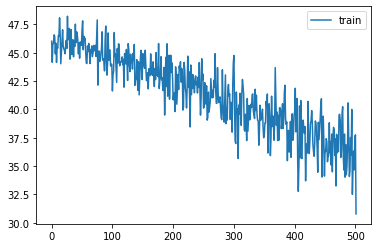

In [217]:
train_loss, valid_loss = train_epoch()

Epoch train loss: 2.0180, Epoch valid loss: 1.9449
Epoch train loss: 1.9005, Epoch valid loss: 1.8913
Epoch train loss: 1.8650, Epoch valid loss: 1.8718
Epoch train loss: 1.8508, Epoch valid loss: 1.8639
Epoch train loss: 1.8448, Epoch valid loss: 1.8608


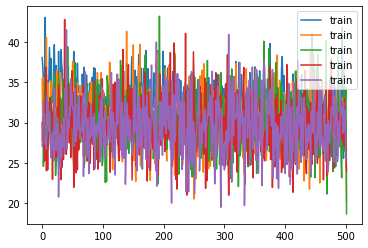

In [187]:
for _ in range(5):
    train_loss, valid_loss = train_epoch()

### Model inference

In [225]:
accurate = 0
model.eval()
for valid_data in valid_dataloader:
    name_tensor = valid_data["name_tensor"]
    language_idx = valid_data["language_idx"]
    
    with torch.set_grad_enabled(False):
        logits = model(name_tensor)
        preds = torch.argmax(logits, axis=1)
        accurate += torch.sum(preds==language_idx).item()
    
print(f"Validation accuracy: {accurate / len(valid_dataloader.dataset):.4f}")

Validation accuracy: 0.4625


### Prediction for single name

In [248]:
name = "ashok"

In [249]:
name_tensor = name_to_tensor(name, max_len)
logits = model(name_tensor.unsqueeze(0))
pred = torch.argmax(logits, axis=1)
language = idx_to_language[pred.item()]

In [250]:
print(f"Index: {pred.item()}, Language: {language}")

Index: 14, Language: Russian


In [107]:
x = model.embedding(name_to_tensor("asasas", max_len).unsqueeze(1))

In [108]:
x.shape

torch.Size([19, 1, 10])

In [109]:
o, h = model.rnn(x)

In [111]:
o.shape, h.shape

(torch.Size([19, 1, 10]), torch.Size([1, 1, 10]))

In [237]:
for data in train_dataloader:
    x = data
    break

In [238]:
name_tensor = x["name_tensor"]
language_idx = x["language_idx"]

In [239]:
name_tensor.shape

torch.Size([32, 19])

In [240]:
x = model.embedding(name_tensor.transpose(0, 1))

In [241]:
x.shape

torch.Size([19, 32, 10])

In [242]:
o, h = model.rnn(x)

In [243]:
o.shape, h.shape

(torch.Size([19, 32, 10]), torch.Size([1, 32, 10]))

In [244]:
h[-1].shape

torch.Size([32, 10])

In [246]:
logits = model.linear(h[-1])
logits.shape

torch.Size([32, 18])

In [171]:
language_idx.shape

torch.Size([27])

In [172]:
loss_function(logits, language_idx)

tensor(81.3065, grad_fn=<NllLossBackward>)

In [251]:
language_idx

tensor([ 4,  4, 14, 15,  0, 14, 14, 14, 14,  4,  5, 14, 14,  9, 14, 14, 14, 14,
        14,  6, 14, 14, 14, 10, 14, 14, 14,  0,  6, 14, 14,  4])